# Binary Classification in Python - Bank Marketing

<p>The data used in this project consists of information acquired during direct marketing campaigns of a Portuguese banking institution. The main task here is to predict if the client will subscribe a term deposit or not.</p>
<p>This dataset was taken from Kaggle website. The file used for predictions, <em>bank.csv</em>, is available <a href="https://www.kaggle.com/sonujha090/bank-marketing">here</a>, along with more detailed description.</p>
<p>I am going to start with some exploratory data analysis, followed by data cleaning and preprocessing. Then, after selecting relevant features, I will try to perform machine learning techniques to predict the most accurate output, using both linear and tree-based algorithms, making a comparison of these two approaches.</p>
<p>To begin with, I will import neccessary packages and functions and load the dataset.</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import warnings

warnings.simplefilter('ignore')


%matplotlib inline

In [2]:
data = pd.read_csv("bank.csv")

## Exploratory Data Analysis
<p>After making all the imports and loading dataset, it is natural step to overview our data. We can see, that there are 16 variables and the output variable <em>y</em>, which can be divided into 3 groups:</p>
<p><b>Bank client data:</b></p> 
<p>1 - age (numeric) 2 - job: type of job (categorical: "admin", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student", "blue-collar", "self-employed", "retired", "technician", "services") 3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed) 4 - education (categorical: "unknown","secondary","primary","tertiary") 5 - default: has credit in default? (binary: "yes","no") 6 - balance: average yearly balance, in euros (numeric) 7 - housing: has housing loan? (binary: "yes","no") 8 - loan: has personal loan? (binary: "yes","no")</p>
<p><b>Data related with to last contact of the current campaign:</b></p>
<p>9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 10 - day: last contact day of the month (numeric) 11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec") 12 - duration: last contact duration, in seconds (numeric)</p>
<p><b>Other attributes:</b></p>
<p>13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted) 15 - previous: number of contacts performed before this campaign and for this client (numeric) 16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")</p>
<p>The output variable (desired target), y, records the information if the client has subscribed a term deposit? (binary: "yes","no")</p>

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
data.shape

(4521, 17)

In [5]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


<p>As we can see, there are 10 categorical variables and 7 numeric features. It seems that data is in good shape and does not need cleaning, i.e. there are no missing values. Below is the summary of both continuous and categorical variables.</p>

In [7]:
# A subset of numeric data for future use. Also a convenient way to display characteristics of the variables.
data_numeric = data[data.describe().columns]
data_numeric.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [8]:
# A subset of categorical data for future use. Also a convenient way to display characteristics of the variables.
data_categorical = data[data.describe(include=["object"]).columns]
data_categorical.describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,yes,no,cellular,may,unknown,no
freq,969,2797,2306,4445,2559,3830,2896,1398,3705,4000


<p>In the numeric subset, it is noticeable that the variables <b>pdays</b> and <b>previous</b> are strongly imbalanced - both of them are dominated by -1 and 0 values respectively. In both cases, at least up to the 75th percentile, all records in <i>pdays</i> equal -1 and every value in <i>previous</i> equals 0.</p>
<p>As for the categorical variables, we can observe that in the <b>poutcome</b> column, for 3705 observations the outcome of the previous marketing campaign is unknown. We can consider them as missing data, which makes this column a strong candidate to be removed, since it does not give us much information. Moreover, 4000 out of 4521 clients have not subscribed to the bank's offer, so there is a huge imbalance in the output variable.</p>
<p>Before removing <i>poutcome</i> variable, it might be reasonable to check if there is any binding between number of clients who previously subscribed to the bank's offer and who subscribed to the current offer. As mentioned before, at first glance, due to many missing values, it seems <i>poutcome</i> should be removed. However, it might occur that there is huge probability, that if client previously subscribed to the offer, then he or she will be more likely to accept current offer.</p>

In [9]:
# 2 subsets of clients who subscribed to the service and who did not. Both will be also usefull to visualize the class
# imbalance later.
data_yes = data[data["y"] == "yes"]
data_no = data[data["y"] == "no"]

data_yes["poutcome"].value_counts()

unknown    337
success     83
failure     63
other       38
Name: poutcome, dtype: int64

<p>The figure above shows the counts of previous campaign result among the clients, who subscribe to the offer during current campaign. The percentage of this fration among subscribers is:</p>

In [10]:
print(round(len(data_yes[data_yes["poutcome"] == "success"])/len(data_yes)*100, 2),"%", sep='')

15.93%


In [11]:
data["poutcome"].value_counts()

unknown    3705
failure     490
other       197
success     129
Name: poutcome, dtype: int64

<p>On the contrary, here I am going to check how big is the group of clients who subscribed during previous campaign comparing to the whole population in the dataset:</p>

In [12]:
print(round(len(data[data["poutcome"] == "success"])/len(data)*100, 2),"%", sep='')

2.85%


<p>It turns out that among people, who currently subscribe the deposit term, 15.93% of them subscribed the deposit term previously as well. The overall number of clients who previously subscribed to the bank's offer constitutes 2.85% of all tested clients, so we can observe a slight correlation of these 2 traits. Due to huge imbalance of the dataset and the low overall number of "yes" records, we might assume that this feature is relevant.</p>
<p>Now I will investigate another 2 suspicious columns, <i>pdays</i> and <i>previous</i>, populated mostly by -1 and 0 respectively. I am going to check the exact counts of both values:</p>

In [13]:
print("Number of 'pdays' records equal to -1:",len(data[data.pdays == -1]),"\nNumber of 'previous' records equal to 0:",
      len(data[data.previous == 0]))

Number of 'pdays' records equal to -1: 3705 
Number of 'previous' records equal to 0: 3705


<p>Both numbers are the same. I will check if <i>pdays</i> equal to -1 means <i>previous</i> equal to 0:</p>

In [14]:
pd.crosstab(data.previous[data.previous == 0], data.pdays)

pdays,-1
previous,
0,3705


<p>It turns out to be true. What is also interesting, the number of 3705 is also the count of "unknown" records in the <i>poutcome</i> variable, what was shown in one of the cells above. It might happen, that "unknown", rather than missing value, is a way to indicate that the client was not previously contacted:</p>

In [15]:
pd.crosstab(data.pdays, data.poutcome[data.poutcome == "unknown"])

poutcome,unknown
pdays,
-1,3705


<p>Both match perfectly. "unknown" indeed means there was not any contact with this client before the current campaign. Taking into account higher probability of subscribing the term deposit among clients who accepted the offer previously, it seems that this column might be valuable for us and it is better to keep it. It is also better to retain <i>pdays</i> and <i>previous</i> variables for now, as, besides the situation described earlier, for clients who have been previously contacted, they may behave completely different.</p>

## Data Cleaning and Preprocessing
<p>Though the <i>pdays</i> column contain some valuable information, instead of leaving the exact number of days that passed since the last contact before the current campaign, for which, in many cases there might be only one observation, we can combine them into some more informative groups. We can assume, that banks usually have 1-2 campaigns during a year and if the client was not contacted during last 6 months, it is rather considered as long period. I will now modify this column, indicating if the client was contacted during last 180 days or not ("never" in case of no contact before).</p>

In [16]:
data_numeric["contact_6m"] = data_numeric["pdays"].apply(lambda val: "never" if val == -1 else
                                                           ("yes" if val <= 180 else "no"))

<p>Since this variable is now no longer numeric and has become categorical, I will add it to the appropriate subset.</p>

In [17]:
contact_6m = data_numeric["contact_6m"]
data_categorical = pd.concat([data_categorical, contact_6m], axis=1)

<p>Instead of keeping track of all of the months, we can group them into quartiles, so we could reduce the number of <i>month</i> classes from 12 to 4:</p>

In [18]:
Q1 = ["jan", "feb", "mar"]
Q2 = ["apr", "may", "jun"]
Q3 = ["jul", "aug", "sep"]
Q4 = ["oct", "nov", "dec"]

data_categorical["month"] = data_categorical["month"].apply(lambda m: "Q1" if m in Q1 else ("Q2" if m in Q2 else
                                                                                            ("Q3" if m in Q3 else "Q4")))

This is how categorical variables look after preprocessing works:

In [19]:
data_categorical.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y,contact_6m
0,unemployed,married,primary,no,no,no,cellular,Q4,unknown,no,never
1,services,married,secondary,no,yes,yes,cellular,Q2,failure,no,no
2,management,single,tertiary,no,yes,no,cellular,Q2,failure,no,no
3,management,married,tertiary,no,yes,yes,unknown,Q2,unknown,no,never
4,blue-collar,married,secondary,no,yes,no,unknown,Q2,unknown,no,never


<p>Since I recoded the variable <i>pdays</i>, I do not need it anymore. I will also delete the <i>contact_6m</i> variable from <i>data_numeric</i>, which remained after above mentioned encoding in this subset and is now doubled with the same column in categorical subset.</p>

In [20]:
to_drop_numeric = ["pdays", "contact_6m"]

data_numeric = data_numeric.drop(to_drop_numeric, axis=1)

<p>Another problem of this dataset, which was not talked before, is the huge variance of some of the numeric columns. Especially variables such as <b>balance</b> and <b>duration</b> suffer from this, having much higher orders of magnitude than the rest of the variables, which is shown in the below figure, followed by 2 plots.</p>

In [21]:
data_numeric.var()

age         1.118562e+02
balance     9.057922e+06
day         6.802402e+01
duration    6.752547e+04
campaign    9.670897e+00
previous    2.868153e+00
dtype: float64

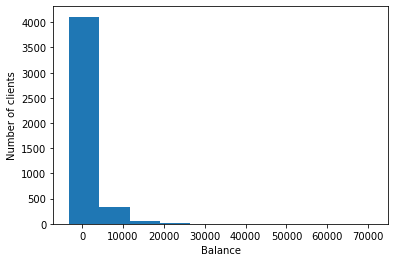

In [22]:
balance_plot = data_numeric['balance'].plot(kind="hist")
balance_plot.set(xlabel="Balance", ylabel="Number of clients")
plt.show()

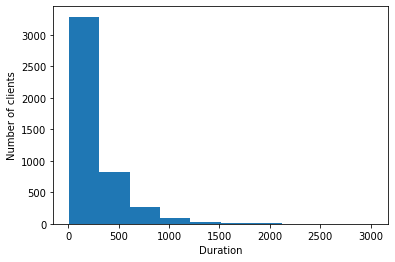

In [23]:
duration_plot = data_numeric['duration'].plot(kind="hist")
duration_plot.set(xlabel="Duration", ylabel="Number of clients")
plt.show()

<p>This can bias the model, resulting in poor performance of our predictions. To face this problem, and ensuring that the variables have distribiution close to the normal, which is needed for many machine learning models, I will now perform log normalization of these values, so they can be used in our models.</p>
<p>However, the <i>balance</i> variable has some negative values, so before normalization, all values must be positive. To deal with this, I will add a value of 3314 to all the observations, so the lowest one, equal to -3313, becomes positive (equal to 1).</p>

In [24]:
data_numeric["balance"] = np.log(data_numeric["balance"] + 3314)
data_numeric["duration"] = np.log(data_numeric["duration"])

We can see now, for example, how the distribution of <i>duration</i> variable looks like:

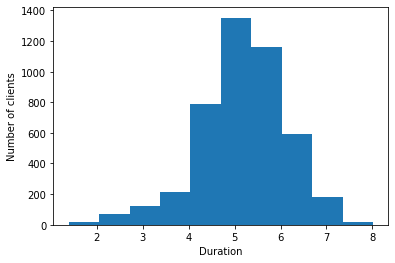

In [25]:
duration_log_plot = data_numeric['duration'].plot(kind="hist")
duration_log_plot.set(xlabel="Duration", ylabel="Number of clients")
plt.show()

<p>Since Scikit-learn models require features to be numeric, I need to encode the categorical variables to the numeric ones. After preprocessing tasks I have now 11 categorical columns, where 4 of them is binary and 7 is multi-class columns. I am going to use different approaches to deal with both of these cases. Next, I will remove the columns in their original form to have only those encoded.</p>

In [26]:
data_categorical.describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,y,contact_6m
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,4,4,2,3
top,management,married,secondary,no,yes,no,cellular,Q2,unknown,no,never
freq,969,2797,2306,4445,2559,3830,2896,2222,3705,4000,3705


In [27]:
# For binary variables, I will use LabelEncoder
le = LabelEncoder()

cat_binary = ["default", "housing", "loan", "y"]

for c in cat_binary:
    data_categorical[c] = le.fit_transform(data_categorical[c])

In [28]:
# For multiclass columns, I will perform one-hot encoding using dummy variables

cat_multi = ["job", "marital", "education", "contact", "month", "poutcome", "contact_6m"]

for c in cat_multi:
    data_categorical = pd.concat([data_categorical,pd.get_dummies(data_categorical[c], prefix=c)],axis=1)
    data_categorical.drop([c],axis=1, inplace=True)

In [29]:
# After normalizing numeric variables and encoding categorical columns, I concatenate all the variables together.
data_cleaned = pd.concat([data_numeric, data_categorical], axis=1)

In [30]:
data_cleaned.head()

,age,balance,day,duration,campaign,previous,default,housing,loan,y,...,month_Q2,month_Q3,month_Q4,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,contact_6m_never,contact_6m_no,contact_6m_yes
0,30,8.537192,19,4.369448,1,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
1,33,8.999990,11,5.393628,1,4,0,1,1,0,...,1,0,0,1,0,0,0,0,1,0
2,35,8.447629,16,5.220356,1,1,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
3,30,8.474286,3,5.293305,4,0,0,1,1,0,...,1,0,0,0,0,0,1,1,0,0
4,59,8.105911,5,5.420535,1,0,0,1,0,0,...,1,0,0,0,0,0,1,1,0,0


<p>Now that all the variables are normalized, I will separate the dependent variable from the features:</p>

In [31]:
features = data_cleaned.drop(["y"], axis=1)
label = data_cleaned["y"]

## Modelling
<p>To meet the goal of this project, i.e. to correctly predict if the client will subscribe to the term deposit or not, I will use few examples of both linear and tree-based classifiers with different settings, trying to choose the one that performs best.</p>
<p>Before splitting the data into train and test sets, it is worth to note one problem of the dataset. As we saw in the EDA step, the output variable <i>y</i> is strongly imbalanced. The situation is shown on the pie chart below:</p>

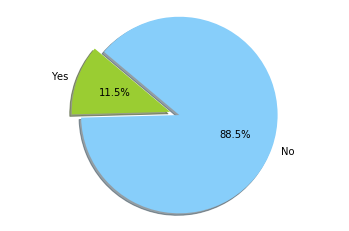

In [32]:
# Here I use the previously created subsets to show the dependent variable imbalance
plt.pie([len(data_yes), len(data_no)], explode=(0.1, 0), labels=('Yes', 'No'),
        colors=['yellowgreen', 'lightskyblue'], autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

<p>Since 88.5% of the outputs is <i>No</i>, it may happen, that during splitting our data, the training set may not "see" the <i>Yes</i> records. To project the distribution of the output variable, I will set the <i>stratify</i> parameter to <i>label</i>, which will help with this problem.</p>

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features, label, stratify=label, test_size=.3)

However, it still doesn't solve the problem. Above mentioned imbalance can make it difficult for the model to approprietly classify the minority label. I therefore use <i>SMOTE</i> method from <i>imblearn.over_sampling</i> module to create synthetic instances of <i>yes</i> label. It will equalize the relation of both classes and will be used only on the training set.

In [34]:
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

y_train_df = pd.DataFrame(y_train, columns = ['label'])
y_train_df.label.value_counts()

1    2799
0    2799
Name: label, dtype: int64

We can see now that both classess have the same number of observations. As it's shown below, the test set still has the same class imbalance.

In [35]:
y_test.value_counts()

0    1201
1     156
Name: y, dtype: int64

To measure the performance of the algorithms, I will use the <i>f1_score</i> metric, which takes into account the weighted average of <i>Precision</i> and <i>Recall</i>. The first term is the ratio of correctly predicted positive observations to the total predicted positive observations, while "recall" is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The best score that f1 metric can take is 1, while 0 is the worst.

### Linear classifiers
<p>The first group of classifiers is linear and it consists of <b>Logistic Regression</b> and <b>SVM</b>. Due to huge imbalance of the class, I have set the <i>average</i> parameter of f1_score to "weighted".</p>

In [36]:
# Logistic Regression with default parameters

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression f1_score:", f1_score(y_test, y_pred_lr, average='weighted'))

Logistic Regression f1_score: 0.8300199925192816


Logistic Regression model with default settings achieved f1_score of 0.83. Below is more detailed output, where we can investigate how this model deals with correct classification of both classess.

In [37]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1201
           1       0.34      0.76      0.47       156

    accuracy                           0.80      1357
   macro avg       0.65      0.78      0.67      1357
weighted avg       0.89      0.80      0.83      1357



The interesting fact is that our model was capable to correctly classify <b>76%</b> of class 1 which, taking into account original imbalance of the data, seems to be quite good result. We can see that by looking at the <i>recall</i> value. The Confusion matrix shows more clear output.

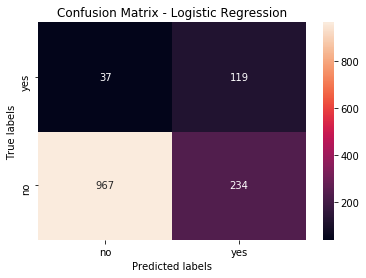

In [48]:
conf_mat_lr = confusion_matrix(y_test, y_pred_lr)
ax = plt.subplot()
sns.heatmap(conf_mat_lr, annot=True, ax=ax, fmt='d')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Logistic Regression')
ax.xaxis.set_ticklabels(['no', 'yes'])
ax.yaxis.set_ticklabels(['no', 'yes'])
ax.set_ylim([0,2])
plt.show()

<p>Out of <b>156</b> observations belonging to the class "yes" our model correctly classified <b>119</b> of them. Considering the original ratio 88,5% to 11,5%, with this model we are 3 times more successful, as the <i>precission</i>, equal to 0.34, tells us that 34% of "yes" predictions are correct.</p>

<p>The next alogrithm used is <b>SVM</b>.</p>

In [40]:
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM f1_score:", f1_score(y_test, y_pred_svm, average='weighted'))

SVM f1_score: 0.8555459330571228


The f1 score is higher than the one achieved by Logistic Regression model.

In [41]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1201
           1       0.53      0.13      0.21       156

    accuracy                           0.89      1357
   macro avg       0.71      0.56      0.58      1357
weighted avg       0.85      0.89      0.86      1357



However, as we can see, the SVM model completely fails when it comes to correctly classify the "yes" class and it maximises its f1 metric by correct filtering the "no" label.

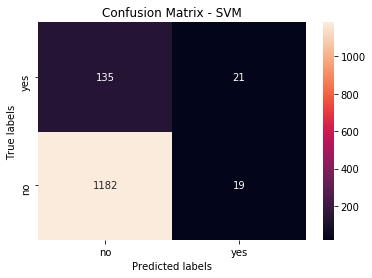

In [47]:
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)
ax = plt.subplot()
sns.heatmap(conf_mat_svm, annot=True, ax=ax, fmt='d')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - SVM')
ax.xaxis.set_ticklabels(['no', 'yes'])
ax.yaxis.set_ticklabels(['no', 'yes'])
ax.set_ylim([0,2])
plt.show()

As shown above, only 21 out of 156 "yes" labels were detected.

Our first result induces to take a try at tuning our model to get even better results. Here I am going to tune the model using GridSearchCV to find the best combination of hyperparameters.

In [50]:
param_grid_lr2 = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400],
             'penalty': ['l1', 'l2']}

grid_lr2 = GridSearchCV(LogisticRegression(), param_grid_lr2, cv=5, return_train_score=True)

grid_lr2.fit(X_train, y_train)
grid_lr2.best_params_

{'C': 10, 'penalty': 'l1'}

In [52]:
lr2 = LogisticRegression(C=10, penalty='l1')

lr2.fit(X_train, y_train)
y_pred_lr2 = lr2.predict(X_test)

print("Logistic Regression f1_score:", f1_score(y_test, y_pred_lr2, average='weighted'))

Logistic Regression f1_score: 0.8307176238191446


In [53]:
print(classification_report(y_test, y_pred_lr2))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1201
           1       0.34      0.77      0.47       156

    accuracy                           0.80      1357
   macro avg       0.65      0.79      0.67      1357
weighted avg       0.89      0.80      0.83      1357



<p>Tuning Logistic Regression model did not help a lot. It's a bit better in detecting positive label than our first model.</p>

### Tree-based classifiers
<p>The next set of models consists of Tree-based classifiers such as Decision Tree and Random Forest. For all of the models I will perform tuning in order to find the most accurate model.</p>

In [54]:
dt = DecisionTreeClassifier()

params_dt = {
        'max_depth': range(3, 18, 3),
        'min_samples_leaf': [0.005, 0.01, 0.02],
        'max_features': [0.2, 0.4,0.6, 0.8],
        'class_weight': ['balanced']
            }
grid_dt = GridSearchCV(estimator=dt,
                    param_grid=params_dt,
                    scoring='f1_weighted',
                    cv=10,
                    n_jobs=-1)

grid_dt.fit(X_train, y_train)
y_pred_dt = grid_dt.best_estimator_.predict(X_test)
best_hyperparams = grid_dt.best_params_

print('Best hyperparameters:\n', best_hyperparams)
print('Best f1_score', f1_score(y_test, y_pred_dt, average='weighted'))

Best hyperparameters:
 {'class_weight': 'balanced', 'max_depth': 12, 'max_features': 0.6, 'min_samples_leaf': 0.005}
Best f1_score 0.865816468296371


In [55]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1201
           1       0.41      0.46      0.43       156

    accuracy                           0.86      1357
   macro avg       0.67      0.69      0.68      1357
weighted avg       0.87      0.86      0.87      1357



<p>Comparing to previous 3 models, the f1_score achieved by Decision Tree is the highest. Unfortunately, it's worse in correct classification of "yes" class.</p>

In [56]:
rfc = RandomForestClassifier()

params_rfc = {
            'n_estimators': [50, 100, 200, 500],
            'max_depth': range(6, 15, 3),
            'min_samples_leaf': [0.0005, 0.001, 0.005, 0.01],
            'max_features': ['log2', 'sqrt'],
            'class_weight': ['balanced']
            }

grid_rfc = GridSearchCV(estimator=rfc,
            param_grid=params_rfc,
            cv=5,
            scoring='f1_weighted',
            verbose=1,
            n_jobs=-1)

grid_rfc.fit(X_train, y_train)
y_pred_rfc = grid_rfc.best_estimator_.predict(X_test)
best_hyperparams_rfc = grid_rfc.best_params_


print('Best hyperparameters:\n', best_hyperparams_rfc)
print('f1_score on best estimator', f1_score(y_test, y_pred_rfc, average='weighted'))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  3.6min finished


Best hyperparameters:
 {'class_weight': 'balanced', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 0.0005, 'n_estimators': 50}
f1_score on best estimator 0.8716457122677054


In [57]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1201
           1       0.49      0.31      0.38       156

    accuracy                           0.88      1357
   macro avg       0.70      0.63      0.66      1357
weighted avg       0.87      0.88      0.87      1357



<p>Random Forest achieved even higher f1 result. As we can see, it's better in detecting "no" label than Decision Tree and worse in classifying the other class.</p>

Being a bank that is offering a term deposit for their clients, we may want be better at correct classification of "yes" label, since losing such opportunity is much more "expensive" for us than calling a client, that won't eventually subscribe to our offer. I will therefore change the scorring to "recall" for the next 2 models to see if we can get better at this.

In [60]:
dt2 = DecisionTreeClassifier()

params_dt2 = {
        'max_depth': range(3, 18, 3),
        'min_samples_leaf': [0.005, 0.01, 0.02],
        'max_features': [0.2, 0.4,0.6, 0.8],
        'class_weight': ['balanced']
            }
grid_dt2 = GridSearchCV(estimator=dt2,
                    param_grid=params_dt2,
                    scoring='recall',
                    cv=10,
                    n_jobs=-1)

grid_dt2.fit(X_train, y_train)
y_pred_dt2 = grid_dt2.best_estimator_.predict(X_test)
best_hyperparams = grid_dt2.best_params_

print('Best hyperparameters:\n', best_hyperparams)
print('Best f1_score', f1_score(y_test, y_pred_dt2, average='weighted'))

Best hyperparameters:
 {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 0.8, 'min_samples_leaf': 0.01}
Best f1_score 0.8020388851353664


In [61]:
print(classification_report(y_test, y_pred_dt2))

              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1201
           1       0.29      0.76      0.42       156

    accuracy                           0.76      1357
   macro avg       0.63      0.76      0.64      1357
weighted avg       0.88      0.76      0.80      1357



In [65]:
print(confusion_matrix(y_test, y_pred_dt2))

[[918 283]
 [ 38 118]]


As we can see, the Decision Tree model achieved lower f1 score. However, we are now detecting 76% of all the clients that will agree to our offer. The algorithm is now more likely to classify an observation as "yes", which, on the other hand, poses a bigger effort to us to call all of them.

In [62]:
rfc2 = RandomForestClassifier()

params_rfc2 = {
            'n_estimators': [50, 100, 200, 500],
            'max_depth': range(6, 15, 3),
            'min_samples_leaf': [0.0005, 0.001, 0.005, 0.01],
            'max_features': ['log2', 'sqrt'],
            'class_weight': ['balanced']
            }

grid_rfc2 = GridSearchCV(estimator=rfc2,
            param_grid=params_rfc2,
            cv=5,
            scoring='recall',
            verbose=1,
            n_jobs=-1)

grid_rfc2.fit(X_train, y_train)
y_pred_rfc2 = grid_rfc2.best_estimator_.predict(X_test)
best_hyperparams_rfc2 = grid_rfc2.best_params_


print('Best hyperparameters:\n', best_hyperparams_rfc2)
print('f1_score on best estimator', f1_score(y_test, y_pred_rfc2, average='weighted'))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  4.4min finished


Best hyperparameters:
 {'class_weight': 'balanced', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 0.0005, 'n_estimators': 200}
f1_score on best estimator 0.8682579315450171


In [63]:
print(classification_report(y_test, y_pred_rfc2))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1201
           1       0.43      0.41      0.42       156

    accuracy                           0.87      1357
   macro avg       0.68      0.67      0.67      1357
weighted avg       0.87      0.87      0.87      1357



In [64]:
print(confusion_matrix(y_test, y_pred_rfc2))

[[1116   85]
 [  92   64]]


<p>Random Forest has similar score for f1 metric and 43% of its "yes" predictions are correct. Unfortunately, we're missing 85 out of 156 clients that would subscribe to the bank's offer.</p>

## Summary

<p>Based on the presented models, we see that various algorithms can be characterized by different efficiency on a given data set. Choosing the best of them is not an obvious task, because their quality depends on the goal we want to achieve. The highest value of f1 metric was achieved by the <b>Random Forest</b> classifier. However, depending on the situation, we may not always consider it as the best model.</p>
<p>The bank can proceed in two ways. With large staff resources and low operational costs, the organization would probably choose the <b>Logistic Regression</b> or <b>Decision Tree</b> model, as both provided the highest effectiveness in terms of the number of customers who actually subscribed to the offer. However, if the bank wanted to reduce the amount of work and optimise the "contact-agreement" ratio, above mentioned Random Forest model, with <i>precision</i> value of 0.49, could be more profitable, as it means that half of the clients contacted by the bank would agree to make a term deposit.</p>